In [4]:
# log_path = 'negative_possibility/2025-12-03/11-56-47'
# log_path2 = "negative_possibility/2025-12-01/"
# # # log_path3 = 'Square_distance/2025-11-28/10-59-04'
# # match_log = 'fixed_value/2025-10-24/16-59-25'
# log_name = 'fixed_value_training.log'

log_path = 'gradient_based_method'
# log_path2 = "DSGD_lr_schedule_full_training/2025-12-09/17-26-20"
#log_path3 = 'DSGD_partial_activation/2025-12-03/17-32-13/metropolis_hasting-gradient:False-equal_test_set:False'
# match_log = 'matcha_lr_decay/2025-10-28/17-26-25'
log_name = 'main.log'
import numpy as np
import re
import os
from omegaconf import OmegaConf
from flp2p.utils import compute_weight_matrix
import networkx as nx
import pickle
from flp2p.matcha_mixing_matrix import getAlpha, getProbability, getSubGraphs, graphToLaplacian

def get_metrics(data):
    overall_distance_p = re.compile(r'Overall consensus distance : ([\d\.]+)')
    inter_cluster_distance_p = re.compile(r'Inter-cluster distance : ([\d\.]+)')
    cluster_1_distance_p =  re.compile(r'Cluster 1 consensus distance : ([\d\.]+)')
    cluster_2_distance_p =  re.compile(r'Cluster 2 consensus distance : ([\d\.]+)')
    spectral_gap_p = re.compile(r'Spectral Gap = ([\d\.]+)')
    test_pattern = re.compile(r"Test, Round (\d+) : loss => ([\d\.]+),  accuracy: ([\d\.]+)")
    train_pattern = re.compile(r"Train, Round (\d+) : loss => ([\d\.]+),  accuracy: ([\d\.]+)")
    gradient_norm_pattern = re.compile(r"Train, Round (\d+) : gradient_norm : ([\d\.]+)")
    
    overall_distance, inter_cluster_distance, cluster_1_distance, cluster_2_distance, spectral_gap = [], [], [], [], []
    test_accuracy, train_loss, gradient_norm = [], [], []
    for match in overall_distance_p.finditer(data):
        overall_distance.append(float(match.group(1)))
        
    for match in inter_cluster_distance_p.finditer(data):
        inter_cluster_distance.append(float(match.group(1)))
    
    for match in cluster_1_distance_p.finditer(data):
        cluster_1_distance.append(float(match.group(1)))
           
    for match in cluster_2_distance_p.finditer(data):
        cluster_2_distance.append(float(match.group(1)))
        
    for match in spectral_gap_p.finditer(data):
        spectral_gap.append(float(match.group(1)))
        
    for match in test_pattern.finditer(data):
        test_accuracy.append(float(match.group(3)))
        
    for match in train_pattern.finditer(data):
        train_loss.append(float(match.group(2)))
    
    for match in gradient_norm_pattern.finditer(data):
        gradient_norm.append(float(match.group(2)))

    return {"consensus_distance": overall_distance,
            "inter_cluster_distance": inter_cluster_distance,
            "cluster_1_distance": cluster_1_distance,
            "cluster_2_distance": cluster_2_distance,
            "spectral_gap": spectral_gap,
            'test_accuracy': test_accuracy,
            "gradient_norm": gradient_norm}
    
def extract_res(log_file, results, log_name):
    with open(f'{log_file}/{log_name}', 'r') as f:
        data = f.read()
    config_file = OmegaConf.load(f'{log_file}/.hydra/config.yaml') 
    with open(f'{log_file}/graph.pickle', 'rb') as f:
        graph = pickle.load(f)
            
    W = compute_weight_matrix(graph, config_file.mixing_matrix)
    eigenval = sorted(np.linalg.eig(W).eigenvalues, reverse=True)
    algebric_value = 1 - max(abs(eigenval[1]), abs(eigenval[-1]))
    res_dict = get_metrics(data)
    dict_key  =f'{log_file.split('/')[-2]}_{log_file.split('/')[-1]}_{config_file.mixing_matrix}'
    results[dict_key] = res_dict
    results[dict_key]['main_link_activation'] = config_file.graph.main_link_activation
    results[dict_key]['border_link_activation'] = config_file.graph.border_link_activation
    if results[dict_key]['main_link_activation'] == 1:
        results[dict_key]['old_gradients'] = True
    results[dict_key]['old_gradients'] = config_file.old_gradients
    results[dict_key]['same_distrib_test_set'] = config_file.same_distrib_test_set
    results[dict_key]['gossiping_step'] = config_file.aggregation_step_per_round
    results[dict_key]['selection_method'] = config_file.selection_method

results = {}
for root, dirs, files in os.walk(log_path):
    if log_name in files:
        log_file_path = root
        extract_res(log_file_path, results, log_name)
   

# for root, dirs, files in os.walk(log_path2):
#     if log_name in files:
#         log_file_path = root
#         extract_res(log_file_path, results, log_name)
        

# for root, dirs, files in os.walk(log_path3):
#     if log_name in files:
#         log_file_path = root
#         extract_res(log_file_path, results, log_name)
        

# for root, dirs, files in os.walk(match_log):
#     if log_name in files:
#         log_file_path = root
#         extract_res(log_file_path, results, log_name)

In [14]:
list(results.keys())

['2025-12-09_17-26-05_metropolis_hasting']

In [60]:
results['2025-12-04_14-24-09_jaccard']['spectral_gap']

[]

In [26]:
index_elems

['consensus_distance',
 'inter_cluster_distance',
 'cluster_1_distance',
 'cluster_2_distance',
 'spectral_gap',
 'test_accuracy',
 'gradient_norm',
 'main_link_activation',
 'border_link_activation',
 'old_gradients',
 'same_test_distrib']

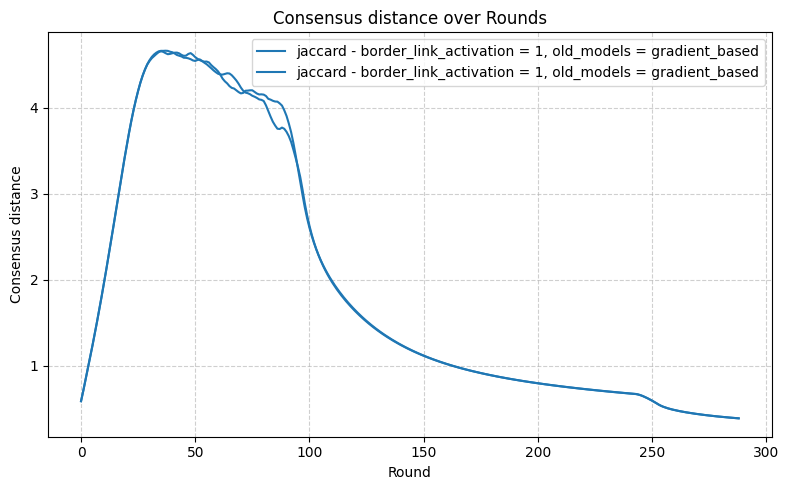

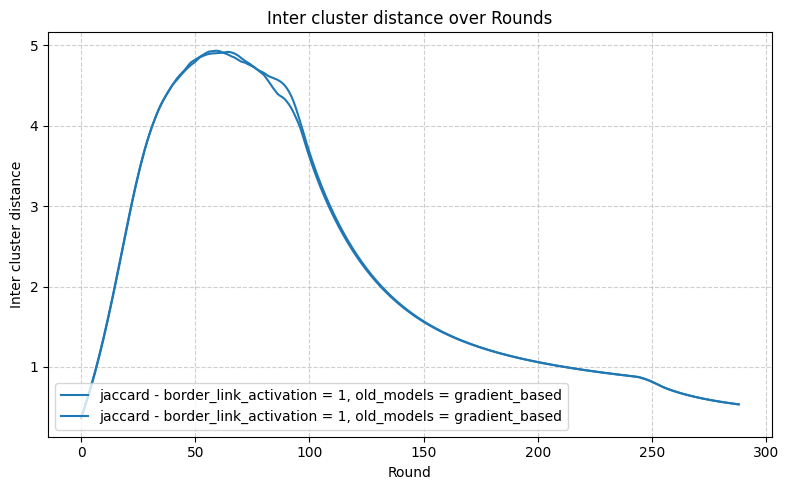

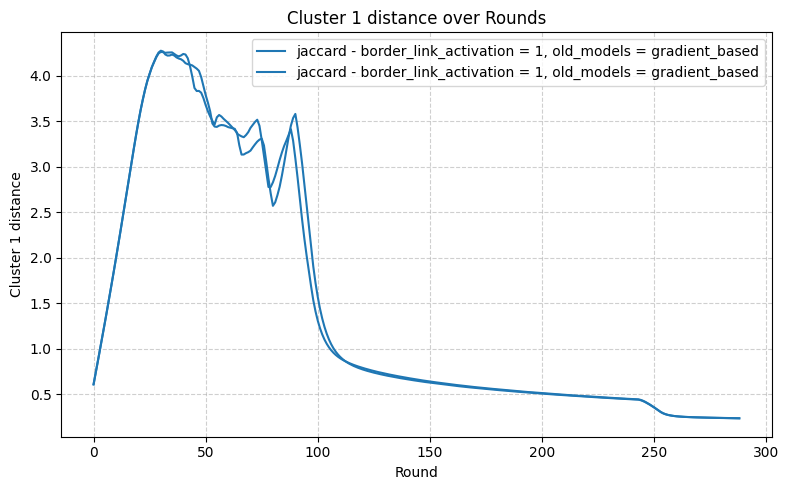

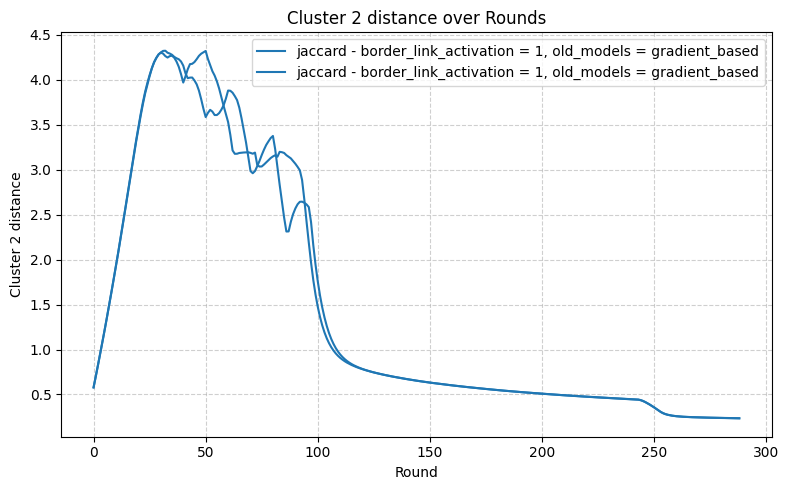

<Figure size 800x500 with 0 Axes>

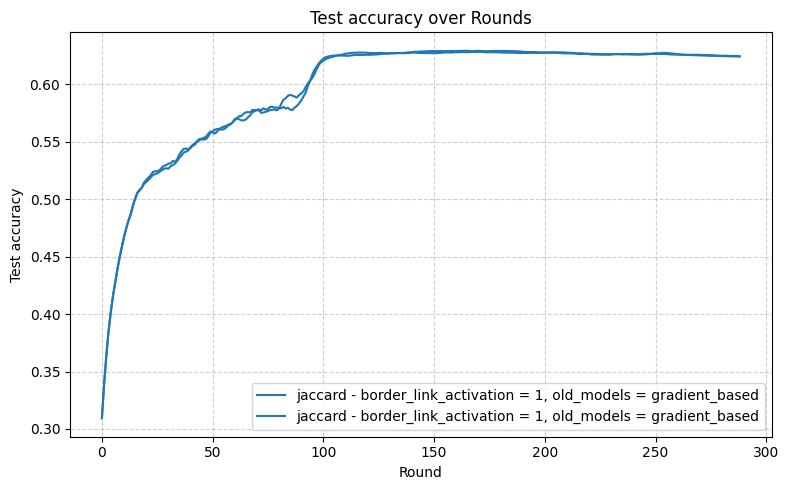

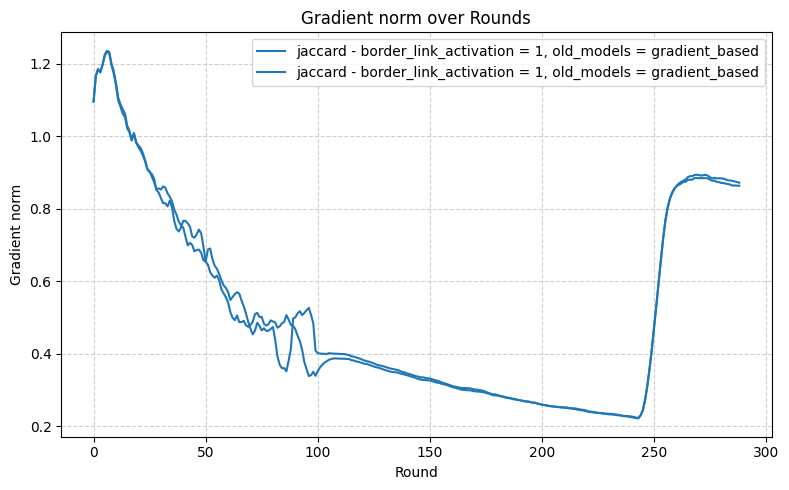

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
keys = list(results.keys())
index_elems = list(results[keys[0]].keys())
epochs = min(1000, min(len(results[k][index_elems[0]]) for k in keys)) 
start = 0
unique_old_gradients = sorted(set(f"{results[k]['old_gradients']}-{k.split('_')[-1]}-{results[k]['border_link_activation']}-{results[k]['selection_method']}" for k in results.keys()))
color_cycle = plt.cm.tab10.colors  # 10 distinct colors (you can use more: tab20, viridis, etc.)
color_map = {og: color_cycle[i % len(color_cycle)] for i, og in enumerate(unique_old_gradients)}
for index_elem in index_elems:
    plt.figure(figsize=(8, 5))
    if type(results[list(results.keys())[0]][index_elem]) is not list or len(results[list(results.keys())[0]][index_elem]) == 0:
        continue
    for key in keys:
        if results[key]['same_distrib_test_set']  is False:
            y = results[key][index_elem]
            y = np.convolve(y[start:epochs], np.ones(10)/10)[10:-10]
            rounds = np.arange(start, start + len(y))
            g_matrix = key.split('_')[-1]
            if g_matrix != 'matcha':
                label = f"{g_matrix} - border_link_activation = {results[key]['border_link_activation']}, old_models = {results[key]['selection_method']}"
            # if index_elem == "spectral_gap":
            #label = f"{g_matrix} - border_link_activation = {results[key]['border_link_activation']}"
            # else:
            #     label = f"{g_matrix} - {"Memory activated" if results[key]['old_gradients'] else "Memory desactivated"}"
            color = color_map[f"{results[key]['old_gradients']}-{g_matrix}-{results[key]['border_link_activation']}-{results[key]['selection_method']}"]
            plt.plot(rounds, y, label=label, color=color)

    plt.xlabel("Round")
    plt.ylabel(index_elem.replace('_', ' ').capitalize())
    plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
# for index_elem in index_elems:
#     plt.figure(figsize=(8, 5))
#     if type(results[list(results.keys())[0]][index_elem]) is not list:
#         continue
#     for key in ['09-53-21_matcha-False-lenet5_matcha', '11-01-36_maximum_degree-False-lenet5_maximum_degree', '11-01-36_metropolis_hasting-False-lenet5_metropolis_hasting']:
#         y = results[key].get(index_elem, None)
#         y = y[start:epochs]
#         rounds = np.arange(start, start + len(y))
#         label = f"{key.split('_')[-1]} - border_link_activation = {results[key]['border_link_activation']}"
#         plt.plot(rounds, y, label=label)
    
#     plt.xlabel("Round")
#     plt.ylabel(index_elem.replace('_', ' ').capitalize())
#     plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds (CIFAR-10, ResNet18)")
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.show()

In [9]:
results['2025-12-09_17-26-05_metropolis_hasting']

{'consensus_distance': [4.921625,
  7.245427,
  9.611669,
  11.890195,
  13.779596,
  14.483633,
  14.762105,
  15.293795,
  15.884081,
  16.277239,
  16.978687,
  17.362844,
  17.404705,
  17.440683,
  17.414749,
  17.507061,
  17.495405,
  17.510521,
  17.547102,
  17.326906,
  17.082449,
  16.877739,
  16.579666,
  16.214481,
  16.056221,
  16.198889,
  16.230688,
  15.989023,
  15.602622,
  15.699048,
  16.780924,
  16.483709,
  16.151985,
  15.825984,
  15.63933,
  15.687606,
  15.547413,
  15.181403,
  14.825227,
  14.405568,
  14.003384,
  13.89844,
  13.635578,
  13.359598,
  13.157791,
  13.0797,
  13.071198,
  12.848659,
  12.816891,
  12.543039,
  12.410778,
  12.328655,
  12.39378,
  12.297628,
  12.095861,
  12.178817,
  12.616353,
  14.916954,
  14.639061,
  14.631343,
  13.855634,
  13.3746,
  12.962471,
  12.782393,
  12.431952,
  12.076116,
  11.853527,
  11.703509,
  11.691118,
  11.681314,
  11.418773,
  11.174831,
  11.202312,
  11.128189,
  10.914559,
  10.844508,


In [7]:
results['17-53-42_jaccard-False-lenet5_jaccard']['test_accuracy']

KeyError: '17-53-42_jaccard-False-lenet5_jaccard'

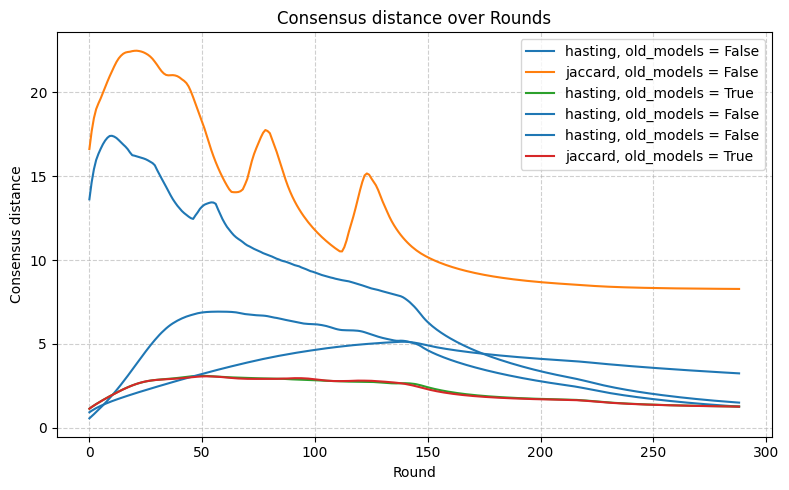

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

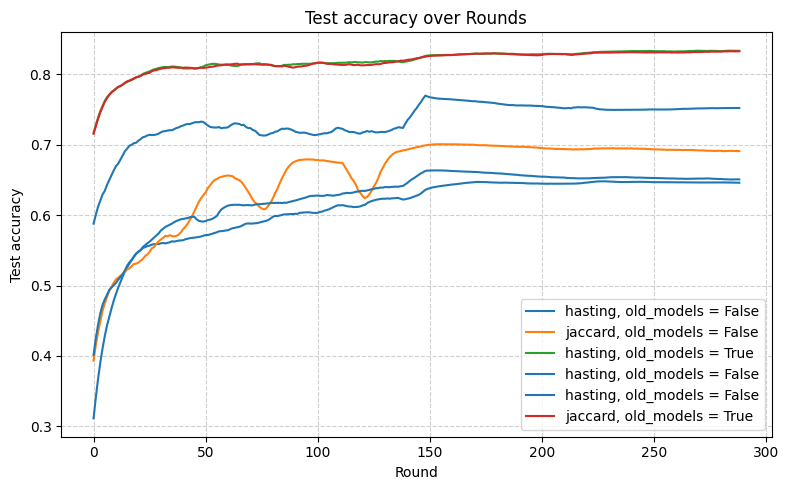

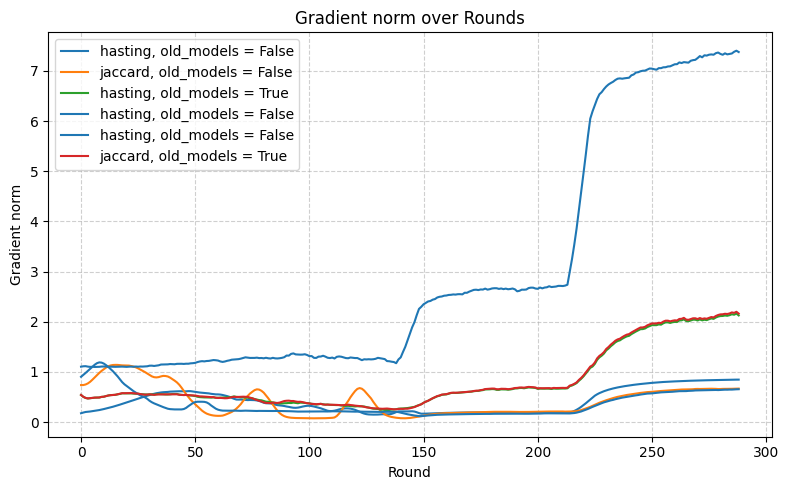

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
keys = list(results.keys())
index_elems = list(results[keys[0]].keys())
epochs = min(1000, min(len(results[k][index_elems[0]]) for k in keys)) 
start = 0
unique_old_gradients = sorted(set(f"{results[k]['old_gradients']}-{k.split('_')[-1]}" for k in results.keys()))
color_cycle = plt.cm.tab10.colors  # 10 distinct colors (you can use more: tab20, viridis, etc.)
color_map = {og: color_cycle[i % len(color_cycle)] for i, og in enumerate(unique_old_gradients)}
for index_elem in index_elems:
    plt.figure(figsize=(8, 5))
    if type(results[list(results.keys())[0]][index_elem]) is not list or len(results[list(results.keys())[0]][index_elem]) == 0:
        continue
    for key in keys:
        if results[key]['same_distrib_test_set']  is False:
            y = results[key][index_elem]
            y = np.convolve(y[start:epochs], np.ones(10)/10)[10:-10]
            rounds = np.arange(start, start + len(y))
            g_matrix = key.split('_')[-1]
            if g_matrix != 'matcha':
                label = f"{g_matrix}, old_models = {results[key]['old_gradients']}"
            # if index_elem == "spectral_gap":
            #label = f"{g_matrix} - border_link_activation = {results[key]['border_link_activation']}"
            # else:
            #     label = f"{g_matrix} - {"Memory activated" if results[key]['old_gradients'] else "Memory desactivated"}"
            color = color_map[f"{results[key]['old_gradients']}-{g_matrix}"]
            plt.plot(rounds, y, label=label, color=color)

    plt.xlabel("Round")
    plt.ylabel(index_elem.replace('_', ' ').capitalize())
    plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
# for index_elem in index_elems:
#     plt.figure(figsize=(8, 5))
#     if type(results[list(results.keys())[0]][index_elem]) is not list:
#         continue
#     for key in ['09-53-21_matcha-False-lenet5_matcha', '11-01-36_maximum_degree-False-lenet5_maximum_degree', '11-01-36_metropolis_hasting-False-lenet5_metropolis_hasting']:
#         y = results[key].get(index_elem, None)
#         y = y[start:epochs]
#         rounds = np.arange(start, start + len(y))
#         label = f"{key.split('_')[-1]} - border_link_activation = {results[key]['border_link_activation']}"
#         plt.plot(rounds, y, label=label)
    
#     plt.xlabel("Round")
#     plt.ylabel(index_elem.replace('_', ' ').capitalize())
#     plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds (CIFAR-10, ResNet18)")
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.show()

In [12]:
for log_dir in os.listdir(log_path):
    log_file  = f'{log_path}/{log_dir}'
    if os.path.isfile(log_file):
        continue
    if log_dir == "15-38-50":
        continue
    with open(f'{log_file}/fixed_value_training.log', 'r') as f:
        data = f.read()
    config_file = OmegaConf.load(f'{log_file}/.hydra/config.yaml') 
    with open(f'{log_file}/graph.pickle', 'rb') as f:
        graph = pickle.load(f)  
    if config_file.mixing_matrix == 'matcha':
        algebric_values = []
        W = list()
        n_nodes = len(graph.nodes)
        subgraphs = getSubGraphs(graph, n_nodes)
        laplacians = graphToLaplacian(subgraphs, n_nodes)
        probas = getProbability(laplacians, 2/5)
        alpha = getAlpha(laplacians, probas, n_nodes)
        for _ in range(config_file.train.rounds):
            L_k = np.sum([laplacians[i] for i in range(len(subgraphs)) if np.random.random() < probas[i]], axis=0)
            eigenval = sorted(np.linalg.eig(np.eye(n_nodes) - alpha * L_k).eigenvalues, reverse=True)
            algebric_values.append(1 -max(abs(eigenval[1]), abs(eigenval[-1])))

FileNotFoundError: [Errno 2] No such file or directory: 'DSGD_shinkhorn/2025-11-25/11-26-35/jaccard-True-lenet5/fixed_value_training.log'